In [65]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image

In [66]:
%pwd

'/mnt/c/Users/sv/source/Enhancement/Image-Enchancer/Images'

In [4]:
import os
os.chdir("../Images")


In [67]:
import numpy as np
from scipy.ndimage import gaussian_filter
 
def estimate_noise(image):
    # Convert to grayscale if the image is colored
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply a Gaussian blur to the image
    blurred = gaussian_filter(image, sigma=1)
    # Subtract the blurred image from the original image to get the high-frequency components
    high_pass = image - blurred
    # The standard deviation of the high-pass image is an estimate of the noise level
    noise_std = np.std(high_pass)
    return noise_std

In [68]:
def apply_denoising_if_needed(image, noise_threshold):
    # Estimate the noise level
    noise_level = estimate_noise(image)
    print(f"Estimated Noise Level: {noise_level}")
 
    # Check if noise level exceeds the threshold
    if noise_level > noise_threshold:
        print(f"Noise level exceeds the threshold of {noise_threshold}. Applying Gaussian blur...")
        # Apply Gaussian blur to reduce noise
        denoised_image = cv2.medianBlur(image, ksize=3)
    else:
        print(f"Noise level is below the threshold of {noise_threshold}. No blurring applied.")
        denoised_image = image
 
    return denoised_image

Estimated Noise Level: 113.5219382938602
Noise level exceeds the threshold of 10. Applying Gaussian blur...
Image saved as 'denoised_image.jpg'. You can view it using an image viewer.


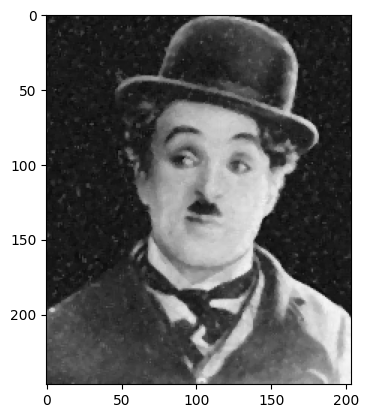

In [69]:
# Load your image

image_path = "./noisy.jpg" # Replace with your image path

image = cv2.imread(image_path)
#image = cv2.resize(image, (224, 224)) 

if image is None:
    print("image is not loaded correctly")
 
# Define a noise threshold
noise_threshold = 10  # Adjust this value based on your needs
 
# Apply denoising if the noise level exceeds the threshold
denoised_image = apply_denoising_if_needed(image, noise_threshold)


 
# Show the result
denoised_image_rgb = cv2.cvtColor(denoised_image, cv2.COLOR_BGR2RGB)

# cv2.imshow("Denoised Image", denoised_image_rgb)
cv2.imwrite("denoised_image.jpg", denoised_image)
print("Image saved as 'denoised_image.jpg'. You can view it using an image viewer.")

plt.imshow(denoised_image_rgb)

# Blur detection

In [59]:
def detect_blur_fft(image, threshold=150):
    # Convert to grayscale if the image is colored
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    
    # Apply Fast Fourier Transform (FFT)
    f = np.fft.fft2(gray)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1)  # Avoid log(0)
    
    # Compute the mean of the magnitude spectrum
    mean_val = np.mean(magnitude_spectrum)
    
    print(f"Mean Frequency Magnitude: {mean_val}")
    
    # If the mean value is below the threshold, the image is considered blurry
    if mean_val < threshold:
        print("Image is blurry.")
        return True
    else:
        print("Image is not blurry.")
        return False

In [60]:
def wiener_filter(image, kernel_size=5, noise_variance=0.01):
    # If the image is colored, apply Wiener filter to each channel
    if len(image.shape) == 3:
        channels = cv2.split(image)
        denoised_channels = [wiener_filter_channel(c, kernel_size, noise_variance) for c in channels]
        return cv2.merge(denoised_channels)
    else:
        return wiener_filter_channel(image, kernel_size, noise_variance)

In [61]:
def wiener_filter_channel(channel, kernel_size=5, noise_variance=0.01):
    # Estimate the local mean
    local_mean = cv2.blur(channel, (kernel_size, kernel_size))
    
    # Estimate the local variance
    local_var = cv2.blur(channel**2, (kernel_size, kernel_size)) - local_mean**2
    
    # Calculate the noise variance
    noise_var = noise_variance
    
    # Apply Wiener filter formula
    wiener = local_mean + (np.maximum(local_var - noise_var, 0) / np.maximum(local_var, 1e-10)) * (channel - local_mean)
    
    return np.uint8(wiener)

In [62]:
def process_image(image_path, blur_threshold):
    # Load the image
    image = cv2.imread(image_path)
    
    # Detect blur
    if detect_blur_fft(image, blur_threshold):
        # If the image is blurry, apply Wiener filter
        print("Image is blurry. Applying Wiener filter...")
        processed_image = wiener_filter(image)
    else:
        # If the image is not blurry, leave it as is
        processed_image = image
    
    # Display the result using Matplotlib
    processed_image_rgb = cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB)
    return processed_image_rgb

Mean Frequency Magnitude: 158.30772451489025
Image is not blurry.


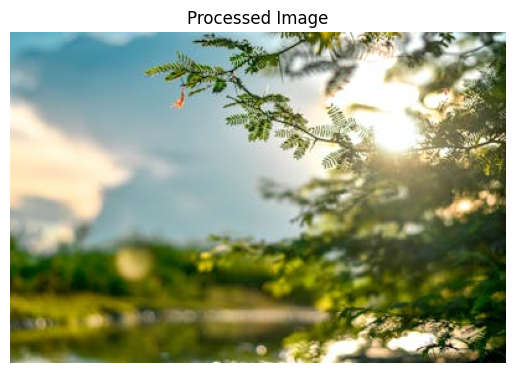

In [64]:
image_path = './blur_image_2.jpg'  # Replace with your image path
blur_threshold = 150  # Set an appropriate threshold for blur detection

image = process_image(image_path, blur_threshold)

# Display the processed image
plt.imshow(image)
plt.title("Processed Image")
plt.axis('off')
plt.show()

In [ ]:
### Code taken from Karthis codebase
def detect_noise(image_np):
    """
        detect_noise: detect the image contains
                    noise or not

        Params:
            - image_np: Numpy array of the image

        return:
            - Noise level of the image
    """
    noise_level = np.std(image_np)
    return noise_level
image_path = "./Giraffe_blur.jpg" 
     # Replace with your image path
image = cv2.imread(image_path)
image_np_1 = np.array(image)
noise_level = detect_noise(image_np_1)
if image is None:
    print(f"Error: Unable to load image at {image_path}")

print(noise_level)

In [36]:

def detect_blur(image_np):
    """
        detect_blur: detect the image contains
                blur or not

        Params:
            - image_np: Numpy array of the image

        return:
            - Blurness of the image
    """
    laplacian = cv2.Laplacian(image_np, cv2.CV_64F)
    variance = laplacian.var()
    return variance

In [37]:
def remove_blur(image_np):
    # remove blur from the image
    kernel = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
    return cv2.filter2D(image_np, -1, kernel)

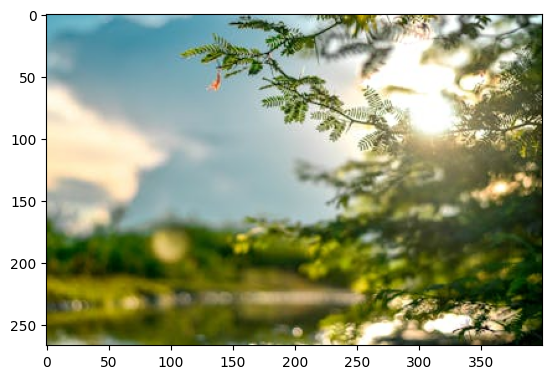

In [40]:
image = Image.open("./blur_image_2.jpg")
image_np = np.array(image)
blur_level = detect_blur(image_np)
if blur_level < 100:
    image_np = remove_blur(image_np)

image = Image.fromarray(image_np)
plt.imshow(image)